# This notebook outlines the analyses described in Fig. 7 and Supp. Fig. 10 of Accurate tiling of spatial single-cell data with Tessera. (Stein, Tran, Korsunsky, 2025)

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(mclust)
    library(dplyr)
    library(ggplot2)
    library(ggthemes)
    library(tidyr)
    library(survival)
    library(ComplexHeatmap)
    library(circlize)
    library(scales)
    library(tidyverse)
    library(corrplot)
    library(survival)
    library(survminer)
    library(sf)
    library(psych)
    library(scattermore)
    library(ggsci)
    library(presto)
})

Sys.setenv(PROJ_LIB = "/PHShome/mpt34/.conda/envs/test/share/proj")

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

generate_colors_tableau<-function (input_vec, verbose = FALSE) 
{
    col_by_values <- unique(input_vec)
    if (verbose) {
        message("Number of unique values: ", length(col_by_values))
    }
    if (length(col_by_values) <= 10) 
        pal_name <- "Tableau 10"
    else pal_name <- "Tableau 20"
    if (verbose) 
        message("Palette chosen: ", pal_name)
    pal <- tableau_color_pal(pal_name)
    max_n <- attr(pal, "max_n")
    if (length(col_by_values) < max_n) {
        cols_plot <- tableau_color_pal(pal_name)(length(col_by_values))
        #names(cols_plot) <- stringr::str_sort(col_by_values, numeric = TRUE)
        names(cols_plot) <- sample(col_by_values)
    }
    else {
        cols_plot <- colorRampPalette(tableau_color_pal(pal_name)(max_n))(length(col_by_values))
        names(cols_plot) <- stringr::str_sort(col_by_values, numeric = TRUE)
    }
    return(cols_plot)
}

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘survminer’ was built under R version 4.3.3”
Warning message:
“package ‘psych’ was built under R version 4.3.3”
Warning message:
“package ‘scattermore’ was built under R version 4.3.3”
Warning message:
“package ‘ggsci’ was built under R version 4.3.3”


## Load Data.

In [2]:
# Post QC single cell level IHC LUAD data. 
og <- readRDS("cells_v4a_qcd.rds")
# Tile level tessera output.
obj_agg <- readRDS("full_panel_luad_tile_cluster_seur.rds")
obj_agg_shapes <- readRDS("full_panel_luad_tile_cluster_seur.rds")
# Cell level tessera output. 
pts_meta <- readRDS("full_panel_luad_tile_cluster_pts.rds")
# Patient level clinical meta data
clin_meta <- read.csv("luad_clin.csv")
clin_meta <- mutate(clin_meta, SampleID = gsub("LUAD_", "",clin_meta$SampleID))

In [3]:
# Define cluster names and color mappings for figure
# Cluster names a based on enriched cell types. See preprocessing step 2.
new.cluster.ids <- c("interstitial_1", #interstitial
                     "tumor_1", #tumor
                     "tumor_2", #tumor
                     "immune_mixed", #T_rich
                     "T_rich_1", #T_rich
                     "tumor_3", #tumor
                     "tumor_div", #tumor_div
                     "neutro_rich_1", #neutro_rich
                     "interstitial_2", #interstitial
                     "immune_inv_1", #myl_rich
                     "T_rich_2", #T_els
                     "tumor_4", # tumor
                     "tumor_invaded", # tumor_dying 
                     "interstitial_3", # interstitial
                     "immune_inv_2", # myl_invading
                     "neutro_rich_2", # neutro_rich 
                     "B_rich" # B_els
                    )

mid.cluster.ids <- c("Interstitial", # interstitial
                        "Tumor", #other_tumor
                        "Tumor", #other_tumor
                        "T_Rich", #other_immune
                        "T_Rich", #other_immune
                        "Tumor", # other_tumor
                        "Tumor_Dividing", #tumor_div
                        "Neutrophil_Rich", #other_immune
                        "Interstitial", #interstitial
                        "Myeloid_Rich", # other_immune
                        "T_Hub", # T_els
                        "Tumor", # other_tumor
                        "Tumor_Dying", #tumor_dying
                        "Interstitial", #interstitial
                        "Myeloid_Activated", # myl_invading
                        "Neutrophil_Rich", #other_immune
                        "B_Hub" # B_els
                       )

coarse.cluster.ids <- c(NA,
                        NA,
                        NA,
                        NA,
                        NA,
                        NA,
                        NA,
                        NA,
                        NA,
                        NA,
                        "Lymphoid_Hub",
                        NA,
                        "Myeloid_Hub",
                        NA,
                        "Myeloid_Hub",
                        NA,
                        "Lymphoid_Hub"
                       )

cluster_map <- data.frame("tile_clus"= 0:16, tile_name = new.cluster.ids) %>%
    mutate(coefficient =paste0("c_",tile_clus))
cluster_map$tile_clus <- as.factor(cluster_map$tile_clus)

cluster_map$mid_tile_id <- as.factor(mid.cluster.ids)
cluster_map$coarse_tile_id <- as.factor(coarse.cluster.ids)
head(cluster_map)

,tile_clus,tile_name,coefficient,mid_tile_id,coarse_tile_id
,<fct>,<chr>,<chr>,<fct>,<fct>
1,0,interstitial_1,c_0,Interstitial,NA
2,1,tumor_1,c_1,Tumor,NA
3,2,tumor_2,c_2,Tumor,NA
4,3,immune_mixed,c_3,T_Rich,NA
5,4,T_rich_1,c_4,T_Rich,NA
6,5,tumor_3,c_5,Tumor,NA


In [4]:
fig_cols <- readRDS("luad_fig_cols.rds")

In [5]:
#order regions in the order they are introduced in the text 
clus_order <- c("Tumor", 
                "Tumor_Dying",
                "Tumor_Dividing",
                "T_Rich",
                "T_Hub",
                "B_Hub",
                "Myeloid_Activated",
                "Myeloid_Rich",
                "Neutrophil_Rich",
                "Interstitial"
               )

In [6]:
#append meta data to seurat obj
obj_agg_meta <- obj_agg@meta.data %>% 
    
    select(-shape) %>% 
    as.data.frame %>%
    left_join(cluster_map , by = c("seurat_clusters" = "tile_clus"))%>% 
    mutate(mid_tile_id=fct_relevel(mid_tile_id, clus_order))

rownames(obj_agg_meta) <- rownames(obj_agg@meta.data)

obj_agg@meta.data <- obj_agg_meta

In [7]:
names(fig_cols) <- names(fig_cols) %>% fct_relevel(clus_order)

# Figure 7. Anti tumor immunity hubs in lung cancer.
- Data-driven stratification of lung cancer patients with immune-enriched Tessera tile regions.

### Figure components:
- C. Integrative UMAP of Tessera tiles, labeled by tile region types.
- D. Distinct cell type composition of tile region types.
- E. Proportions of region types across 385. high-quality samples.
- F. Forest plot summarizing associations of sample-region abundances with patients' survival outcomes
- G. Pearson correlation matrix of normalized region abundance.
- H. Spatial plot of lymphoid hub.
- I. Spatial plot of myeloid hub.
- J. Per sample proportions of anti-tumor hub types.
- K. Definition of Tessera stratified cohort groups.
- L. Kaplan-Meier survival curvves for patient groups. 
- M. Spatial plots of representative examples from different patient groups

## 7C. Integrative UMAP of Tessera tiles, labeled by tile region types.

NULL

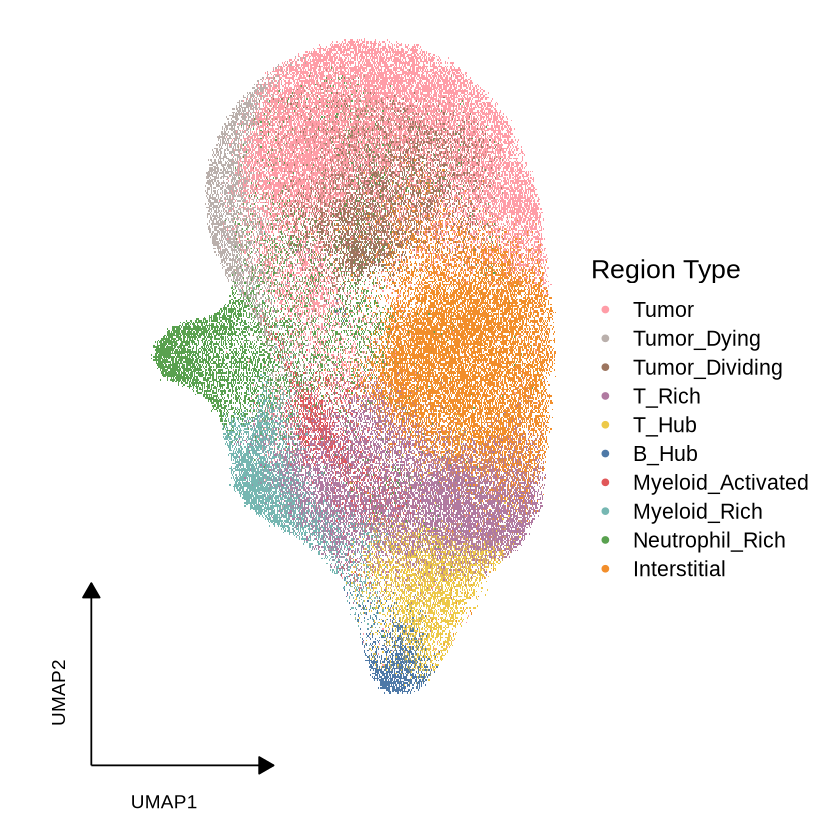

In [8]:
# ggplot version umap 
arr <- list(x = -8, y = -12, x_len = 5, y_len = 5)
cbind(obj_agg@meta.data, obj_agg[["umap"]]@cell.embeddings) %>%
    ggplot(aes(x= umap_2, y= umap_1, col = mid_tile_id))+
    geom_scattermore() + 
    scale_color_manual(values = fig_cols, name = "Region Type") + 
    theme_void(base_size = 16) +
    theme(legend.position ="right")+
    annotate("segment", 
           x = arr$x, xend = arr$x + c(arr$x_len, 0), 
           y = arr$y, yend = arr$y + c(0, arr$y_len), 
           arrow = arrow(type = "closed", length = unit(10, 'pt'))) +
    coord_fixed()+
    annotate("text", y = -10, x = -8.9, label = "UMAP2", size = 4, angle = 90) +
    annotate("text", y = -13, x = -6, label = "UMAP1", size = 4)
    ggtitle("")+ guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4), ncol = 1))
    
        

## 7D. Heatmap of distinct cell type compositions across tile region types.

type2,type3
<fct>,<fct>
tumor,Tumor
Tc,T_Cytotoxic
NA,NA
EC,Endothelial
Mac,Macrophage
Strom_pERK,Stromal
B cell,B_Cell
Th_CD40p,T_Helper
tumor_TFF1_pERK,Tumor


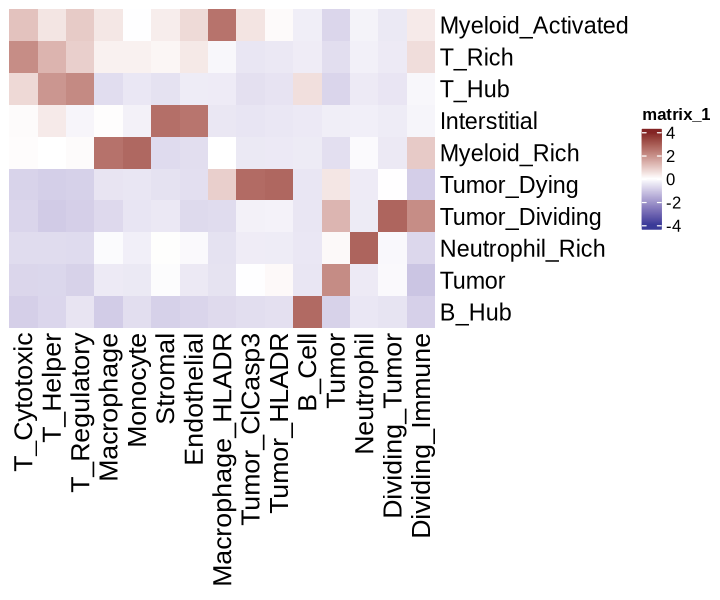

In [9]:
# create mapping to nice cell type names for figure
ct_map <- data.frame(type2 = unique(pts_meta$type2))
ct_map$type3 <-c("Tumor",
                  "T_Cytotoxic",
                  NA,
                 "Endothelial",
                 "Macrophage",
                 "Stromal",
                 "B_Cell",
                 "T_Helper",
                 "Tumor",
                 "Tumor",
                 "T_Regulatory",
                 "Tumor_HLADR",
                 "Neutrophil",
                 "Macrophage_HLADR",
                 "Stromal",
                 "T_Helper",
                 "Monocyte",
                 "Tumor_ClCasp3",
                 "Dividing_Immune",
                 "Dividing_Tumor",
                 "Stromal"
                 ) %>% as.factor
ct_map

# prepare heatmap data
mat <- pts_meta %>% 
    left_join(ct_map, by= "type2") %>%
    left_join(cluster_map , by = c("seurat_clusters" = "tile_clus")) %>%
    with(table(type3, mid_tile_id)) %>% 
    prop.table(2) %>% 
    t %>% scale %>% t 

# plot heatmap
fig.size(5,6)
Heatmap(mat %>% t,
        show_row_dend = F,
        column_names_gp = grid::gpar(fontsize = 16),
        row_names_gp = grid::gpar(fontsize = 14), 
        show_column_dend = F, 
        col = colorRamp2(c(-4, 0, 4), c(muted('blue'), 'white', muted('red'))))

Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”
Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”
Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”


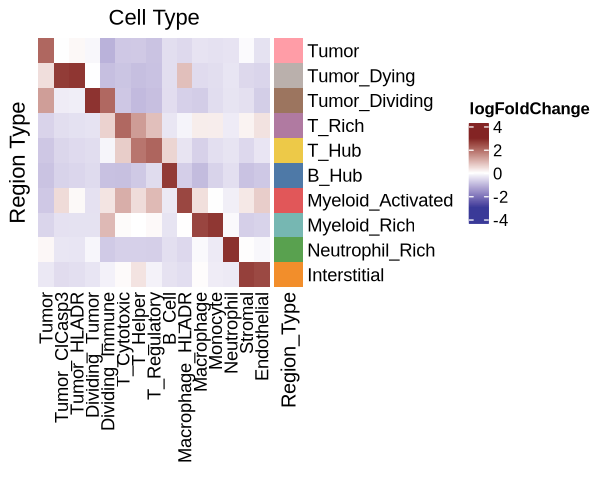

In [10]:
# change ordering and add color consistent mapping for main figure
new_clus_order <- clus_order %>%
    as.factor %>% 
    fct_relevel(clus_order)

ha = rowAnnotation(
    Region_Type = new_clus_order, 
    col = list(Region_Type = fig_cols[new_clus_order]),
    simple_anno_size = unit(.6, "cm"),
    show_legend= FALSE
    
)

col_order <- c("Tumor",
               "Tumor_ClCasp3",
               "Tumor_HLADR",
               "Dividing_Tumor",
               "Dividing_Immune",
               "T_Cytotoxic",
               "T_Helper",
               "T_Regulatory",
               "B_Cell",
               "Macrophage_HLADR",
               "Macrophage",
               "Monocyte",
               "Neutrophil",
               "Stromal",
               "Endothelial"
               
              )
fig.size(4,5)

plt_mat <- mat %>% t
ht <- Heatmap(plt_mat[clus_order,col_order], 
        show_row_dend = F,
        column_names_gp = grid::gpar(fontsize = 11), 
        show_row_names = T,
        cluster_rows = F,
        cluster_columns = F,
        show_heatmap_legend = T,
        heatmap_legend_param = list(title = "logFoldChange",
                                    legend_width = unit(10, "cm"),
                                    legend_height = unit(2, "cm"),
                                    direction = "vertical",
                                    show_legend = T,
                                    heatmap_legend_side = "right"#,
                                    #at = c()
                                   ),
        column_title = "Cell Type",
        row_title = "Region Type",
        row_names_gp = grid::gpar(fontsize = 11), 
        right_annotation = ha,
        show_column_dend = F,
        
        col = colorRamp2(c(-3, 0, 3), 
                         c(muted('blue'), 'white', muted('red')))
       )

draw(ht)

## Normalize niche abundance by area across samples.
- Note: we calculate both normalized abundance as both sqrt(area(niche type x)/total_sample_area) (tiles_wide) and area(niche type x)/total_sample_area (tiles_wide_no_rt)
- sqrt serves as a variance stabilizing transform appropriate for coxph regresssion
- non sqrt metric corresponds to the proportion of area covered by niche x in a sample and is used as an interpretable metric for stratifying patients based on tessera niches

In [11]:
# prep tile abundance matrix


tiles <- obj_agg@meta.data %>%
    #left_join(cluster_map , by = c("seurat_clusters"="tile_clus" )) %>%
    #select(-shape)%>% 
    group_by(Section) %>% 
    mutate(total_area = sum(area)) %>%
    select(Section, mid_tile_id, total_area, area) %>%
    group_by(Section, mid_tile_id) %>%
    summarize(n = n(),
             normalized_area = sum(area)/total_area) %>%
    unique() %>%
    mutate(rt_norm_area = sqrt(normalized_area))

head(tiles)

tiles_wide <- tiles %>%# left_join(cluster_map , by = c("seurat_clusters"="tile_clus" )) %>%
    ungroup() %>%
    select(Section, rt_norm_area, mid_tile_id) %>% #
    pivot_wider(names_from = mid_tile_id, values_from = rt_norm_area) ##
tiles_wide[is.na(tiles_wide)] <- 0
head(tiles_wide)


tiles_wide_no_rt <- tiles %>%# left_join(cluster_map , by = c("seurat_clusters"="tile_clus" )) %>%
    ungroup() %>%
    select(Section, normalized_area, mid_tile_id) %>% #
    pivot_wider(names_from = mid_tile_id, values_from = normalized_area) ##
tiles_wide_no_rt[is.na(tiles_wide_no_rt)] <- 0

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Section', 'mid_tile_id'. You can override
using the `.groups` argument.


Section,mid_tile_id,n,normalized_area,rt_norm_area
<fct>,<fct>,<int>,<dbl>,<dbl>
D001,Tumor,98,0.404266930,0.63581989
D001,Tumor_Dying,3,0.007764974,0.08811909
D001,Tumor_Dividing,1,0.002160435,0.04648048
D001,T_Rich,48,0.114074029,0.33774847
D001,T_Hub,5,0.006482105,0.08051152
D001,Myeloid_Activated,3,0.005328567,0.07299703


Section,Tumor,Tumor_Dying,Tumor_Dividing,T_Rich,T_Hub,Myeloid_Activated,Myeloid_Rich,Neutrophil_Rich,Interstitial,B_Hub
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D001,0.6358199,0.08811909,0.04648048,0.3377485,0.08051152,0.07299703,0.1896662,0.2807247,0.5874890,0.00000000
D002,0.6906086,0.14704376,0.10609275,0.2983116,0.18971813,0.11680122,0.3938752,0.1583004,0.3989001,0.11063002
D003,0.5839778,0.18745049,0.05619633,0.3816101,0.16634278,0.00000000,0.1755808,0.3628141,0.5317777,0.04612887
D004,0.5746683,0.10487906,0.47057893,0.4051801,0.14183383,0.00000000,0.1483052,0.1548138,0.4427567,0.10502036
D005,0.5216674,0.17174667,0.26333095,0.3365381,0.17649446,0.00000000,0.2143729,0.2295682,0.5986270,0.16614212
D006,0.6883261,0.12059740,0.23654115,0.3028293,0.15729787,0.10754599,0.1960493,0.3280641,0.4261877,0.00000000


## 7E. Proportions of region types across 385. high-quality samples.

In [12]:
#PCA tile abundance matrix to get nice ordering for sample proportion bar plot
sample_pca_res <- tiles_wide %>%
    column_to_rownames("Section") %>%
    scale %>% prcomp

sample_pc_mat <- sample_pca_res$x %>%
    as.data.frame() %>%
    rownames_to_column("SampleID")

sample_pc_mat[1:5,1:5]

,SampleID,PC1,PC2,PC3,PC4
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,D001,-0.06184587,-0.3052712,0.1619852,-1.9972408
2,D002,0.56255558,1.1189039,-0.2059757,0.2527905
3,D003,0.41845551,-0.1299322,-0.5202455,-1.2073773
4,D004,0.21424625,-0.5759959,-1.7813947,0.5211368
5,D005,1.22658120,0.2303173,-1.3694209,-0.5298123


,SampleID,tile_cluster,prop
,<fct>,<fct>,<dbl>
1,D001,Tumor,0.0009675381
2,D002,Tumor,0.0006812258
3,D003,Tumor,0.0006318616
4,D004,Tumor,0.0007404628
5,D005,Tumor,0.0004738962
6,D006,Tumor,0.0009280468


Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


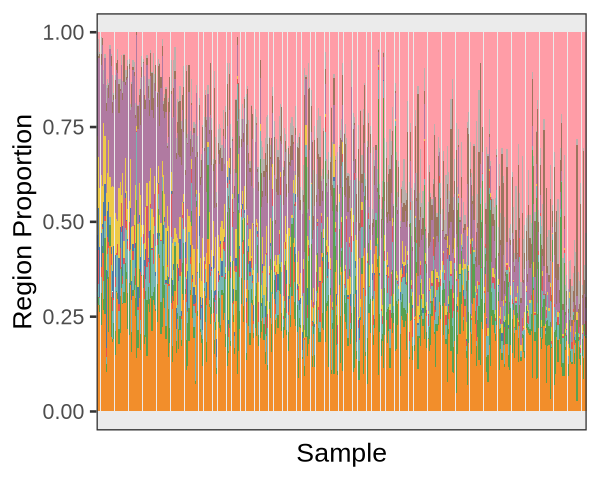

In [13]:
# stacked barplot by composition PC1
plt_props <- table(obj_agg@meta.data$Section,obj_agg@meta.data$mid_tile_id) %>% 
    prop.table() %>% 
    as.data.frame

colnames(plt_props) <- c("SampleID", "tile_cluster", "prop")
head(plt_props)

fig.size(4,5)
plt_props %>%
    left_join(clin_meta) %>%
    left_join(sample_pc_mat) %>% 
    ggplot(aes(fill = tile_cluster, x = reorder(SampleID, -PC1), y= prop))+
        geom_bar(position = "fill", stat= "identity") + 
        theme_bw(base_size = 16)+
        scale_fill_manual(values= fig_cols)+
        theme(
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank()
        )+
        theme(legend.position = "none")+
        xlab("Sample")+
        ylab("Region Proportion")

## 7F. Forest plot summarizing associations of sample-region abundances with patients' survival outcomes

- We perform a Cox Proportional Hazards survival regression to identify niche types with abundances that associate with patient outcome.

In [14]:
# prep data for coxph analysis

cox_survival_df <- inner_join(clin_meta, tiles_wide, by = c("SampleID" = "Section"))
#cox_survival_df_no_rt <- inner_join(clin_meta, tiles_wide_no_rt, by = c("SampleID" = "Section"))

results_list <- list()

for (i in seq_along(colnames(tiles_wide[,-1]))) {
    c_name <- colnames(tiles_wide[,-1])[i]
    formula <- paste("Surv(survival, death_bin) ~ ", c_name, " + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin", sep = "")
    model <- coxph(as.formula(formula), data = cox_survival_df)
    results_list[[i]] <- model
}

coef_data <- lapply(results_list, function(model) {
  coefs <- coef(model) %>% exp
  conf_intervals <- confint(model) %>% exp
  p_values <- summary(model)$coef[, "Pr(>|z|)"]
  data.frame(coefficient = names(coefs),
             estimate = coefs,
             lower_ci = conf_intervals[, 1],
             upper_ci = conf_intervals[, 2],
             p_value = p_values)
})

# Combine results into a single data frame
coef_df <- do.call(rbind, coef_data)

coef_df %>% filter(!grepl("_bin",coefficient)) %>%
    filter(!grepl("hist_pattern",coefficient)) %>% 
    #left_join(cluster_map) %>%
    dplyr::mutate(fdr = p.adjust(p_value, 'BH'))#%>% 



,coefficient,estimate,lower_ci,upper_ci,p_value,fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tumor,Tumor,0.92614968,0.400356287,2.1424747,0.85770983,0.8577098
Tumor_Dying,Tumor_Dying,0.25306164,0.065690838,0.9748725,0.04583093,0.1145773
Tumor_Dividing,Tumor_Dividing,2.59337052,1.077626036,6.2410989,0.03343549,0.1145773
T_Rich,T_Rich,1.52115974,0.469832186,4.9250073,0.48405748,0.8279065
T_Hub,T_Hub,0.19421303,0.040652056,0.9278424,0.03999272,0.1145773
Myeloid_Activated,Myeloid_Activated,0.79464389,0.147491061,4.2813368,0.78907698,0.8577098
Myeloid_Rich,Myeloid_Rich,1.23450840,0.258567560,5.8940533,0.79167759,0.8577098
Neutrophil_Rich,Neutrophil_Rich,1.35673719,0.562847649,3.2703979,0.49674387,0.8279065
Interstitial,Interstitial,0.75095046,0.204170409,2.7620388,0.66644803,0.8577098


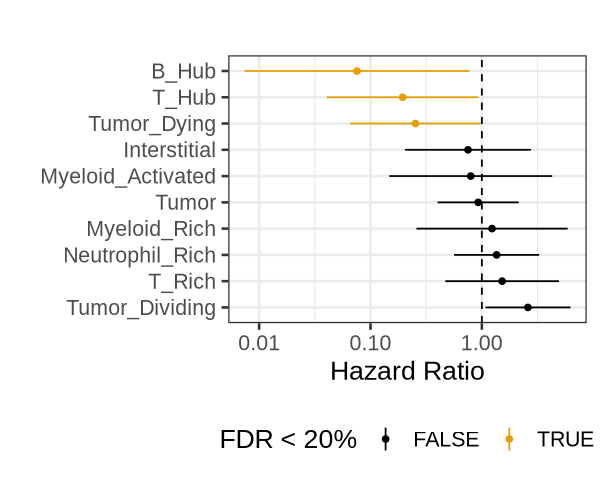

In [15]:
# visualize coxph results with forest plot
fig.size(4,5)
coef_df %>% filter(!grepl("_bin",coefficient)) %>%
    filter(!grepl("hist_pattern",coefficient)) %>% 
    #left_join(cluster_map) %>%
    dplyr::mutate(fdr = p.adjust(p_value, 'BH'))%>% 
    ggplot(aes(x= reorder(coefficient, -estimate), y= estimate, col = (fdr <.20 & log(estimate) < 0)))+
        geom_point() + 
        geom_linerange(aes(ymin = lower_ci, ymax = upper_ci, col = (fdr <.20 & log(estimate) < 0))) +
        theme_bw(base_size = 16)+
        scale_color_colorblind(name = "FDR < 20%")+ 
        #theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
        coord_flip() +
        theme(legend.position = "bottom") + 
        scale_y_continuous(trans= "log10") +
        geom_hline(yintercept = 1, linetype= "dashed")+
        xlab("") + ylab("Hazard Ratio")+
        ggtitle("")

## 7G. Pearson correlation matrix of normalized region abundance.

In [16]:
# Calculate correlation matrix for normalized region abundnace across samples
# cor_res <- tiles_wide %>%
#     column_to_rownames("Section") %>% 
#     cor

# # Corrplot
# fig.size(7,7)
# corrplot(cor_res, type = "lower", order = "hclust", 
#          tl.col = "black", tl.srt = 45, cl.ratio = .2)

,B_Hub,T_Hub,Myeloid_Activated,Tumor_Dying,Myeloid_Rich,T_Rich,Tumor,Tumor_Dividing,Neutrophil_Rich,Interstitial
B_Hub,0.000000e+00,5.826316e-52,1.000000e+00,1.000000e+00,1.000000e+00,4.885209e-03,1.00000000,1,1,1.000000e+00
T_Hub,5.826316e-52,0.000000e+00,1.000000e+00,1.000000e+00,1.267935e-01,2.288937e-22,1.00000000,1,1,1.453351e-01
Myeloid_Activated,1.000000e+00,1.000000e+00,0.000000e+00,1.066746e-14,1.267935e-01,1.267935e-01,1.00000000,1,1,1.000000e+00
Tumor_Dying,1.000000e+00,1.000000e+00,1.066746e-14,0.000000e+00,1.000000e+00,1.000000e+00,0.00372048,1,1,1.000000e+00
Myeloid_Rich,1.000000e+00,1.267935e-01,1.267935e-01,1.000000e+00,0.000000e+00,3.137472e-06,1.00000000,1,1,1.000000e+00
T_Rich,4.885209e-03,2.288937e-22,1.267935e-01,1.000000e+00,3.137472e-06,0.000000e+00,1.00000000,1,1,3.093147e-08
Tumor,1.000000e+00,1.000000e+00,1.000000e+00,3.720480e-03,1.000000e+00,1.000000e+00,0.00000000,1,1,1.000000e+00
Tumor_Dividing,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.00000000,0,1,1.000000e+00
Neutrophil_Rich,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.00000000,1,0,1.000000e+00
Interstitial,1.000000e+00,1.453351e-01,1.000000e+00,1.000000e+00,1.000000e+00,3.093147e-08,1.00000000,1,1,0.000000e+00


Warning message in ind1:ind2:
“numerical expression has 50 elements: only the first used”


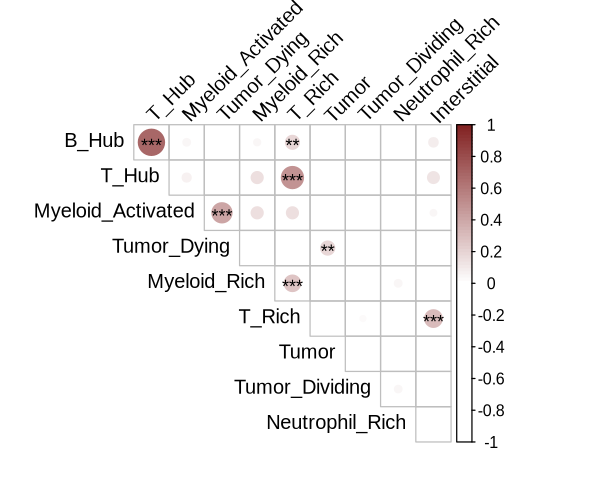

In [17]:
# make corrplot nice for main fig. 
# add pvals, change order.
cor_order <- c('B_Hub','T_Hub','Myeloid_Activated','Tumor_Dying','Myeloid_Rich','T_Rich','Tumor','Tumor_Dividing','Neutrophil_Rich','Interstitial')
input_mat <- tiles_wide %>%
    column_to_rownames("Section") 
cor_res2 <- corr.test(input_mat[,cor_order], method = "spearman") # corr mat for reordered matrix

# p mat adjusted p values are above the diagonal, want to make matrix upper tri by replacing non corrected p vals than add to transpose to make p mat
old_pmat <- cor_res2$p
old_pmat[lower.tri(old_pmat)] <-0

old_pmat2 = (old_pmat + t(old_pmat))
new_pmat <- ifelse(cor_res2$r > 0, old_pmat2, 1)
new_pmat

fig.size(4,5)
corrplot(cor_res2$r,
         type = "upper",
         order = "original", 
         p.mat = new_pmat,
         diag = F,
         insig = "label_sig",
         sig.level = c(0.001,0.01,0.05),
         tl.col = "black", 
         tl.srt = 45, 
         cl.ratio = .2,
         pch.cex = 0.9,
         col = c(rep("white", 50), colorRampPalette(c("white", muted("red")))(50))
        )

## 7H, I. Spatial niche plots of lymphoid (H) and myeloid (I) anti-tumor hubs.

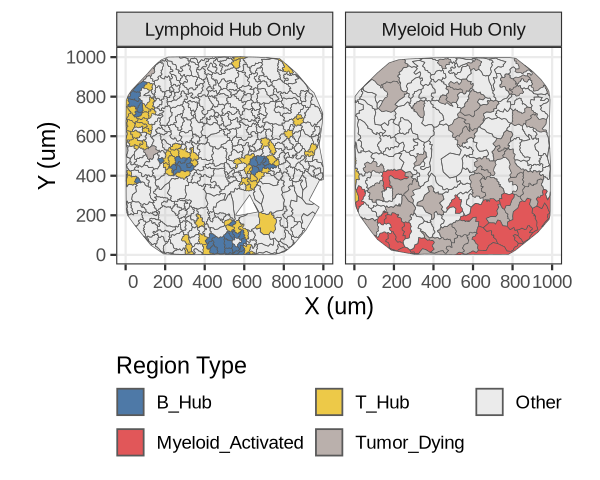

In [18]:
fig.size(4,5)
p1<-obj_agg_shapes@meta.data %>% 
    left_join(cluster_map, by = c("seurat_clusters" = "tile_clus")) %>%
    filter(Section %in% c("D053", "D161")) %>% 
    st_as_sf(sf_column_name = "shape") %>% 
    mutate(coarse_tile_id = if_else(mid_tile_id %in% c("B_Hub", "T_Hub", "Myeloid_Activated", "Tumor_Dying"), mid_tile_id, NA)) %>%
    mutate(group = if_else(Section == "D053", "Lymphoid Hub Only", "Myeloid Hub Only")) %>%
    ggplot() + 
        #geom_point(size = 0.1) + 
        geom_sf(aes(geometry = shape, fill = coarse_tile_id))+
        scale_fill_manual(values= fig_cols, na.value = scales::alpha("grey", .3), labels = c("B_Hub", "Myeloid_Activated", "T_Hub", "Tumor_Dying", "Other")) +
        #scale_color_tableau(palette= "Tableau 20") +
        theme_bw(base_size= 14) +
        facet_wrap(~group, nrow= 1) + 
        coord_sf() +
        theme(legend.position = "bottom")+ 
        guides(fill = guide_legend(title = "Region Type",nrow = 2, title.position = "top"))+ 
        xlab("X (um)") + ylab("Y (um)")
p1

## 7J. Per sample proportions of anti-tumor hub types.

In [19]:
# get nice ordering of samples by anti-tumor hubs

hub_ordered <- tiles %>% 
    select(Section, mid_tile_id, normalized_area)%>%
    mutate(meta_tile_id = case_when(
        mid_tile_id == "T_Hub" ~ "Lymphoid Hub", 
        mid_tile_id == "B_Hub" ~ "Lymphoid Hub", 
        mid_tile_id == "Myeloid_Activated" ~ "Myeloid Hub", 
        mid_tile_id == "Tumor_Dying" ~ "Myeloid Hub", 
        .default = NA
    )%>% as.factor) %>% filter(mid_tile_id == "T_Hub") %>%
    
    #slice(rep(1:nrow(.), each = 3)) %>%
    arrange(-normalized_area) 

head(hub_ordered)

Section,mid_tile_id,normalized_area,meta_tile_id
<fct>,<fct>,<dbl>,<fct>
D329,T_Hub,0.1723171,Lymphoid Hub
D409,T_Hub,0.1607076,Lymphoid Hub
D414,T_Hub,0.1577633,Lymphoid Hub
D177,T_Hub,0.1449863,Lymphoid Hub
D038,T_Hub,0.1325094,Lymphoid Hub
D283,T_Hub,0.1310959,Lymphoid Hub


`summarise()` has grouped output by 'Section'. You can override using the
`.groups` argument.


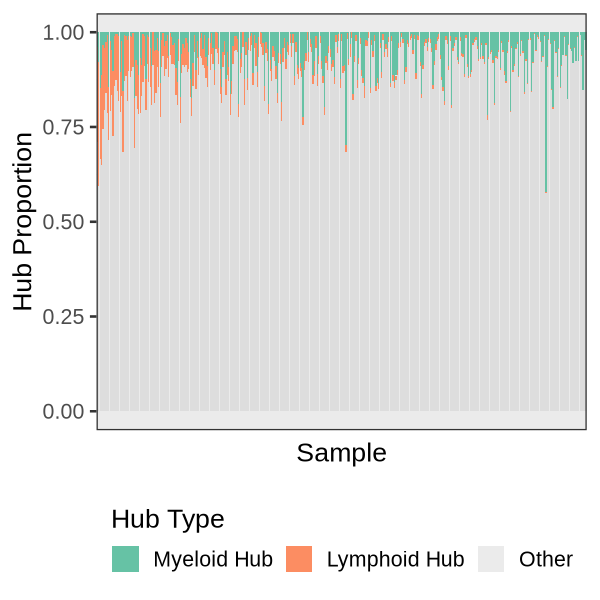

In [20]:
fig.size(5,5)
# Aggregate T_hub and B_hub for lymhoid hub and Myeloid_activated and tumor_dying for myeloid hub.
tiles %>% 
    select(Section, mid_tile_id, normalized_area)%>%
    mutate(meta_tile_id = case_when(
        mid_tile_id == "T_Hub" ~ "Lymphoid Hub", 
        mid_tile_id == "B_Hub" ~ "Lymphoid Hub", 
        mid_tile_id == "Myeloid_Activated" ~ "Myeloid Hub", 
        mid_tile_id == "Tumor_Dying" ~ "Myeloid Hub", 
        .default = NA
    )%>% as.factor) %>% 
    group_by(Section, meta_tile_id) %>%
    summarize(prop = sum(normalized_area)) %>%# head
    left_join(sample_pc_mat, by = c("Section" = "SampleID")) %>% 
    ggplot(aes(fill = meta_tile_id, x = factor(Section, levels = hub_ordered$Section), y = prop))+
        geom_bar(position = "fill", stat= "identity") + 
        theme_bw(base_size = 16)+
        #scale_fill_tableau(palette="Classic 10", name = "Hub Type", na.value = scales::alpha("grey", .3), labels = c("Myeloid Hub", "Lymphoid Hub", "Other"))+
        scale_fill_brewer(palette= "Set2",name = "Hub Type", na.value = scales::alpha("grey", .3), labels = c("Myeloid Hub", "Lymphoid Hub", "Other"))+
        
        theme(#axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+
        theme(legend.position = "bottom")+
        guides(fill = guide_legend(title = "Hub Type",nrow = 1, title.position = "top"))+ 
        xlab("Sample")+
        ylab("Hub Proportion")#+facet_wrap(~hist_pattern, scales= "free")

## 7K. Definition of Tessera stratified cohort groups.

Section,Tumor,Tumor_Dying,Tumor_Dividing,T_Rich,T_Hub,Myeloid_Activated,Myeloid_Rich,Neutrophil_Rich,Interstitial,⋯,smoking_stat_bin,cig_packs_bin,stage_bin,prog_bin,death_bin,survival,hist_pattern,Lymphoid_Hub,Myeloid_Hub,group
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<fct>
D001,0.4042669,0.007764974,0.002160435,0.11407403,0.006482105,0.005328567,0.03597326,0.07880638,0.3451433,⋯,0,1,0,0,1,8.386,3,0.006482105,0.01309354,Pauci-Immune
D002,0.4769402,0.021621868,0.011255672,0.08898982,0.035992968,0.013642524,0.15513764,0.02505901,0.1591213,⋯,0,1,0,1,0,10.111,1,0.048231968,0.03526439,Pauci-Immune
D003,0.3410300,0.035137685,0.003158027,0.14562624,0.027669921,0.000000000,0.03082861,0.13163409,0.2827875,⋯,0,1,0,0,1,2.094,5,0.029797793,0.03513768,Pauci-Immune
D004,0.3302436,0.010999618,0.221444529,0.16417088,0.020116835,0.000000000,0.02199444,0.02396733,0.1960335,⋯,0,1,0,0,1,1.755,4,0.031146111,0.01099962,Pauci-Immune
D005,0.2721368,0.029496918,0.069343189,0.11325791,0.031150294,0.000000000,0.04595573,0.05270157,0.3583543,⋯,0,1,0,0,1,7.598,3,0.058753499,0.02949692,Lymphoid Hub Only
D006,0.4737928,0.014543733,0.055951716,0.09170560,0.024742619,0.011566139,0.03843531,0.10762605,0.1816360,⋯,0,1,0,0,1,5.246,3,0.024742619,0.02610987,Pauci-Immune



  Double-Positive Lymphoid Hub Only  Myeloid Hub Only      Pauci-Immune 
               30                49               149               157 

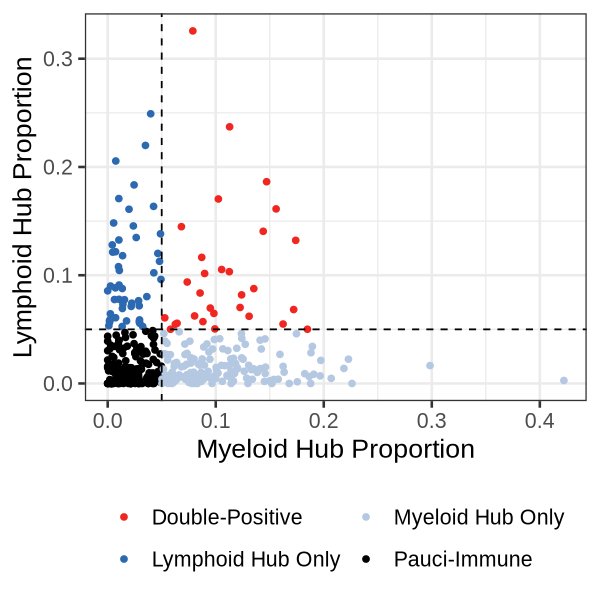

In [21]:
# biaxial gating to stratify patients
# when omitting the square root, these normalized abudnance values correspond to proportion of area covered in the sample
els_cut <- 0.05 # this correponds to >= 5% of the sample area is lymphoid hub
tumor_inv_cut <- 0.05

survival_df <- tiles_wide_no_rt %>% 
    inner_join(clin_meta, by = c("Section" = "SampleID")) %>%
    mutate(Lymphoid_Hub = T_Hub + B_Hub,
          Myeloid_Hub = Tumor_Dying + Myeloid_Activated) %>% 
    mutate(group= case_when(Lymphoid_Hub >= els_cut & Myeloid_Hub >= tumor_inv_cut ~ "Double-Positive",
                               Lymphoid_Hub < els_cut & Myeloid_Hub >= tumor_inv_cut ~ "Myeloid Hub Only",
                               Lymphoid_Hub >= els_cut & Myeloid_Hub < tumor_inv_cut ~ "Lymphoid Hub Only",
                               Lymphoid_Hub < els_cut & Myeloid_Hub < tumor_inv_cut ~ "Pauci-Immune",
                              ) %>% as.factor())





head(survival_df)
fig.size(5,5)
ggplot(survival_df, aes(x = Myeloid_Hub, y= Lymphoid_Hub, col = group)) +
    geom_point() + 
    geom_hline(yintercept = els_cut, linetype = "dashed")+
    geom_vline(xintercept = tumor_inv_cut, linetype= "dashed") +
    theme_bw(base_size= 16)+
    #scale_color_uchicago()+ 
    scale_color_manual(values = c("Lymphoid Hub Only" = "#2c69b0", 
                               "Myeloid Hub Only" = "#b5c8e2", 
                               "Double-Positive" = "#f02720", 
                               "Pauci-Immune" = "black"), 
                     name = "") + 
    xlab("Myeloid Hub Proportion")+ 
    ylab("Lymphoid Hub Proportion")+
    theme(legend.position = "bottom",legend.title=element_blank())+ guides(col=guide_legend(ncol=2))

table(survival_df$group)

## 7L. Kaplan-Meier survival curves for patient groups. 

In [22]:
#Calculate survival curve p values with explicit LRT

#explicit lrt
full_fit_at_all <- coxph(as.formula("Surv(survival, death_bin) ~  1 + group + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df %>% filter(!is.na(group)))
null_fit_at_all <- coxph(as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df  %>% filter(!is.na(group)))

lrt_res <- anova(null_fit_at_all, full_fit_at_all)

full_fit_all_pval <- lrt_res[2,"Pr(>|Chi|)"]

lrt_res

full_fit_all_pval

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-1071.875,NA,NA,NA
2,-1063.049,17.6508,3,0.0005191466


[1] 0.0005191466

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Call: survfit(formula = Surv(survival, death_bin) ~ group, data = survival_df, 
    type = "kaplan-meier")

                          n events median 0.95LCL 0.95UCL
group=Double-Positive    30      7     NA   10.44      NA
group=Lymphoid Hub Only  49     25  10.31    8.30      NA
group=Myeloid Hub Only  149     73  10.86    8.96    15.6
group=Pauci-Immune      157    103   7.41    5.50     9.3

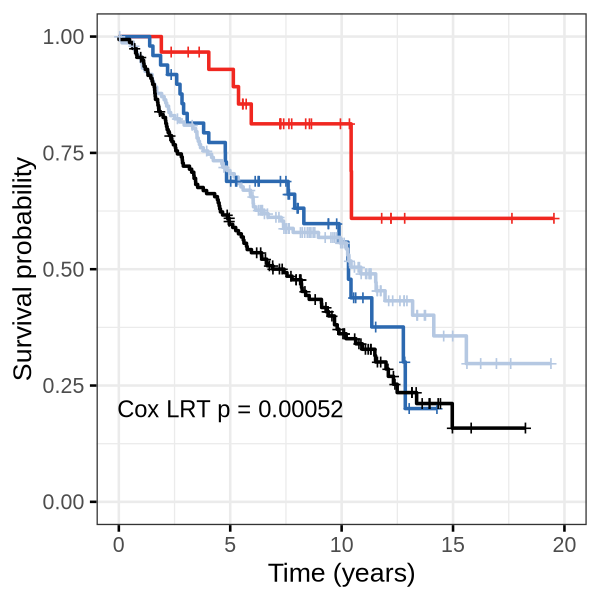

In [23]:
#fig.size(6,4)
#km curves
fit <- survfit(Surv(survival, death_bin) ~ group, data = survival_df, type = "kaplan-meier")
p1 <- ggsurvplot(fit, data = survival_df, pval = FALSE, ggtheme = theme_bw(base_size= 16), palette= "uchicago",legend = "none", legend.title= "", legend.labs = c("Double-Positive", "Lymphoid Hub Only", "Myeloid Hub Only", "Pauci-Immune"))
fig.size(5,5) 
p1$plot + guides(col = guide_legend(ncol=2)) + xlab("Time (years)") +   scale_color_manual(values = c("Lymphoid Hub Only" = "#2c69b0", 
                               "Myeloid Hub Only" = "#b5c8e2", 
                               "Double-Positive" = "#f02720", 
                               "Pauci-Immune" = "black"), 
                     name = "") + annotate("text", x = 5, y = 0.2, label = paste("Cox LRT p =", format(full_fit_all_pval, digits = 2)), 
           size = 5) 

fit


# Supp. Figure 10. Annotation of single cells, characterization of Tessera tiles, and survival analyses from IMC profiling of 385 LUAD patients. 

## Figure components:
- A. Cell UMAP labeled by cell type annotation.
- B. Proportion of cell types across samples.
- C. Heatmap of protein expression markers across cell types.
- D. Histogram of number of cells per Tessera tile.
- E. Correlation of proportion of area covered by T_hub and B_hub
- F. Correlation of proportion of area covered by Tumor_dying and Myeloid_Activated
- G. Spatial niche plots of representative Lymphoid Hub Only samples.
- H. Spatial niche plots of representative Myeloid Hub Only samples.
- I. KM analysis of One AT Hub vs no AT Hubs.
- J. KM analysis of Lymphoid hub only vs Myeloid Hub only.
- K. KM analysis of Double positive vs Lymphoid Hub only.
- L. KM analysis of Double positive vs Myeloid Hub only.
- M. Spatial niche plots of representative double positive samples.


## Supp. 10A. Cell UMAP labeled by cell type annotation.

NULL

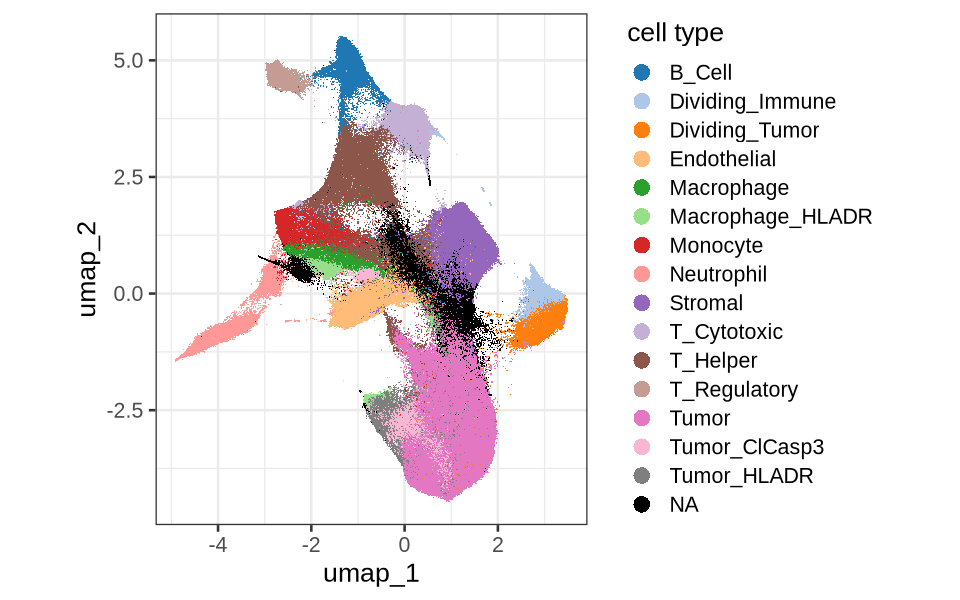

In [24]:
# Append nice cell type names to single cell meta data
og$cells <- left_join(og$cells, ct_map, by= "type2")

fig.size(5, 8)
plt = og$cells %>% 
    cbind(og$U1) %>% 
    ggplot(aes(V1, V2)) + 
        theme_bw(base_size = 16) + 
        coord_fixed()
        NULL

plt +
    xlab("umap_1") + 
    ylab("umap_2")+
    geom_point(shape = '.', aes(color = type3)) + 
    guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = "none") + 
    scale_color_tableau('Classic 20', na.value = "black", name = "cell type")


## Supp. 10B. Proportion of cell types across samples.

### Do PCA on per sample cell type composition to arrange bars nicely by PC1

In [25]:
# arrange heatmap by PC1
sample_ct_pca_res <- table(og$cells$SampleID, og$cells$type3) %>% 
    prop.table(margin=1) %>%
    as.data.frame %>%
    filter(!is.nan(Freq)) %>%
    pivot_wider(names_from = Var2 , values_from = Freq, values_fill = 0) %>%
    column_to_rownames("Var1")%>% 
    scale %>% prcomp

#sample_pca_res$x[1:5,1:5]

sample_ct_pc_mat <- sample_ct_pca_res$x %>%
    as.data.frame() %>%
    rownames_to_column("SampleID")

sample_ct_pc_mat[1:5,1:5]

,SampleID,PC1,PC2,PC3,PC4
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,D050,-1.7064243,-1.2874369,0.18280330,0.30755732
2,D180,3.4575514,0.5010643,-0.49422614,-0.06247121
3,D009,-4.1271685,0.6732701,-0.02560273,0.52651242
4,D341,0.8816007,0.8186255,-2.76067998,0.27094867
5,D134,-0.7134020,1.9112313,2.65579225,-0.40297108


Joining with `by = join_by(SampleID)`
Joining with `by = join_by(SampleID)`


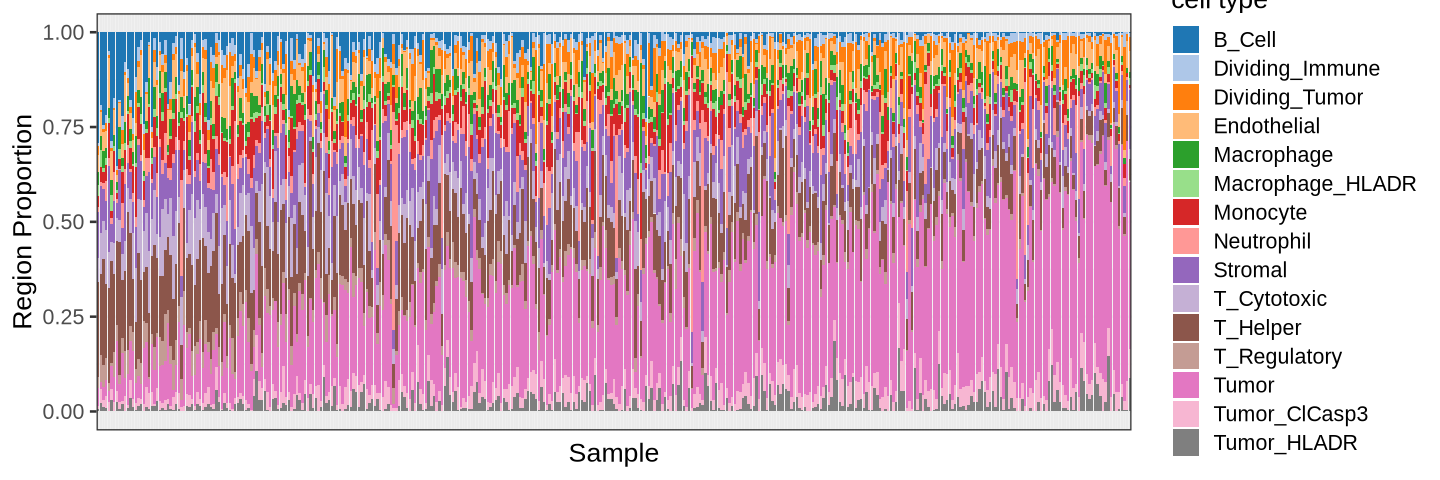

In [26]:
# arrange bar plot by PC! of cell type composition

plt_props <- table(og$cells$SampleID, og$cells$type3) %>% 
    prop.table(margin=1) %>%
    as.data.frame %>%
    filter(!is.nan(Freq))

colnames(plt_props) <- c("SampleID", "type3", "prop")

fig.size(4,12)
plt_props %>%
    left_join(clin_meta) %>%
    left_join(sample_pc_mat) %>% 
    ggplot(aes(fill = type3, x = reorder(SampleID, -PC1), y= prop))+
        geom_bar(position = "fill", stat= "identity") + 
        theme_bw(base_size = 16)+
        #scale_fill_manual(values= fig_cols)+
        theme(#axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+
        theme(legend.position = "right")+
        xlab("Sample")+
        ylab("Region Proportion")+
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = "none") + 
        scale_fill_tableau('Classic 20', na.value = "black", name = "cell type")#+facet_wrap(~hist_pattern, scales= "free")

## Supp. 10C. Heatmap of protein expression markers across cell types.

### Calculate protein markers across cell types with presto wilcoxauc

In [27]:
# markers
M <- wilcoxauc(og$X, as.character(og$cells$type3))


M <- unique(M)
mat = dcast(data.table(M), feature ~ group, value.var = 'logFC') %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() 

head(M)

Removing NA values from labels



,feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CD14,B_Cell,0.018282293,-0.012816448,37372828677,0.4884953,1.471872e-39,1.524439e-39,20.261416,21.653341
2,CD163,B_Cell,0.009207114,-0.006975309,37938757689,0.4958925,8.048096e-10,8.048096e-10,10.796946,11.359739
3,CD16,B_Cell,0.007708267,-0.016765713,35245462588,0.4606888,0.000000e+00,0.000000e+00,8.392733,15.945987
4,CD20,B_Cell,0.467806391,0.461728781,75373629020,0.9851987,0.000000e+00,0.000000e+00,97.787109,5.426266
5,CD31,B_Cell,0.005270537,-0.019435741,36446184665,0.4763832,9.479863e-285,1.057369e-284,6.614970,11.011720
6,CD3,B_Cell,0.111614769,0.015524966,47528881860,0.6212437,0.000000e+00,0.000000e+00,57.183008,27.100837


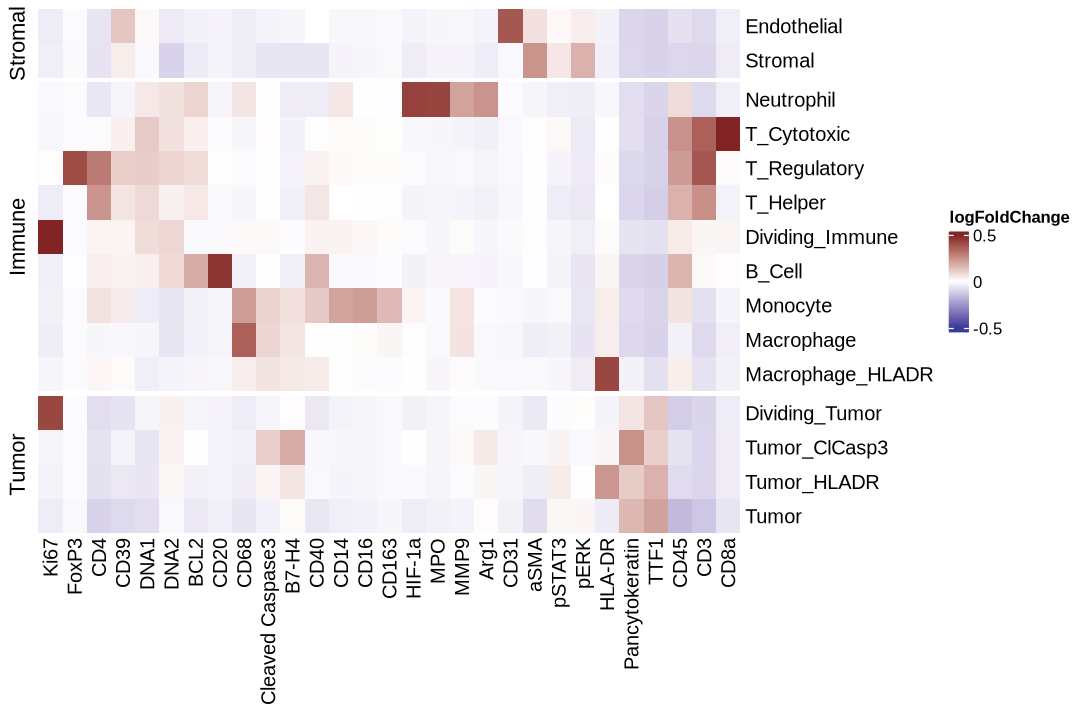

In [39]:
# draw heatmap
# split column gorups 
group_list <- list(
  "Immune" = c("T_Cytotoxic", "Macrophage", "B_Cell", "T_Helper", "T_Regulatory", "Neutrophil", "Macrophage_HLADR", "Monocyte", "Dividing_Immune", "NA"),
  "Stromal" = c("Stromal", "Endothelial"),
  "Tumor" = c("Tumor", "Dividing_Tumor", "Tumor_HLADR", "Tumor_ClCasp3")
)

# Create a vector to indicate the group for each column
column_group <- rep(NA, ncol(mat))
for (group_name in names(group_list)) {
  column_group[colnames(mat) %in% group_list[[group_name]]] <- group_name
}

fig.size(6,9)
Heatmap(mat %>% t, 
        col = colorRamp2(c(-0.5, 0, 0.5), c(muted('blue'), 'white', muted('red'))), 
        row_split = column_group, 
        show_column_dend  = F,
        show_row_dend= F,
        heatmap_legend_param = list(title = "logFoldChange",
                                    #legend_width = unit(10, "cm"),
                                    #legend_height = unit(3, "cm"),
                                    direction = "vertical",
                                    heatmap_legend_side = "right"
                                   )
        
       )

## Supp. 10D. Histogram of number of cells per Tessera tile.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


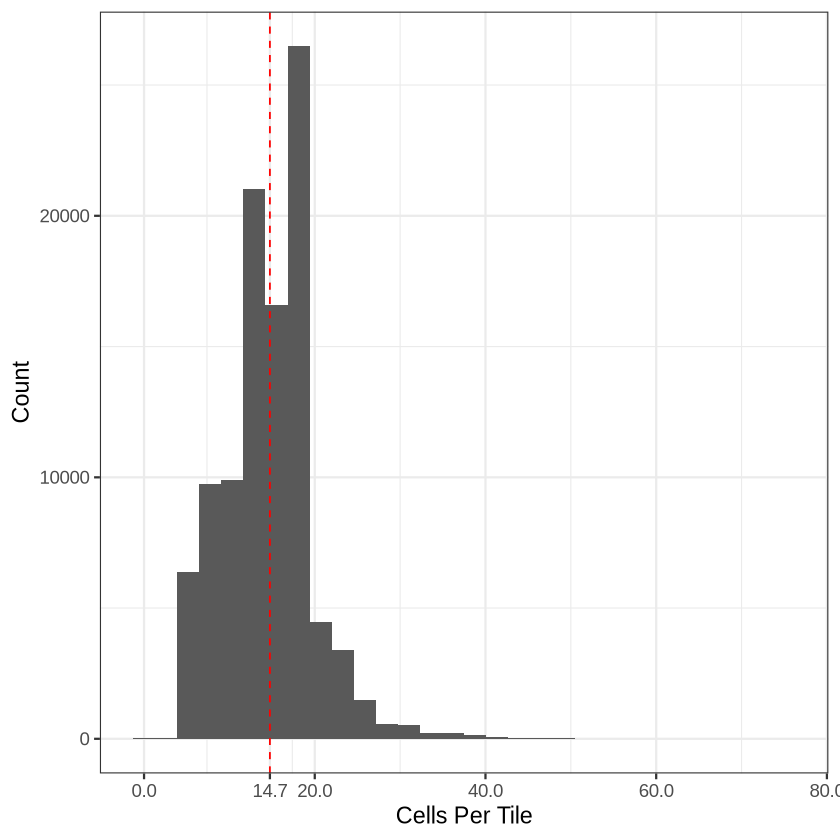

In [29]:
fig.size(7,7)
obj_agg@meta.data %>%
    ggplot(aes(x= npts))+
        geom_histogram()+
        geom_vline(xintercept = mean(obj_agg@meta.data$npts), linetype = "dashed", color = "red") + 
        theme_bw(base_size= 14)+
        xlab("Cells Per Tile")+
        ylab("Count")+
        scale_x_continuous(breaks=c(0,mean(obj_agg@meta.data$npts), 20, 40, 60, 80), labels = scales::number_format(accuracy= 0.1))

## Supp. 10E,F. Correlation of proportion of area covered by (T_hub and B_hub) and (Tumor_dying and Myeloid_Activated) 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


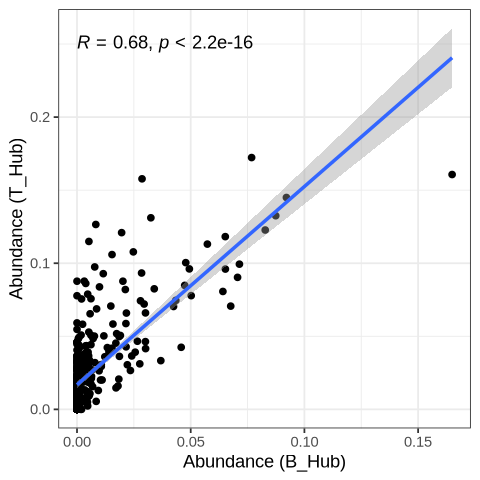

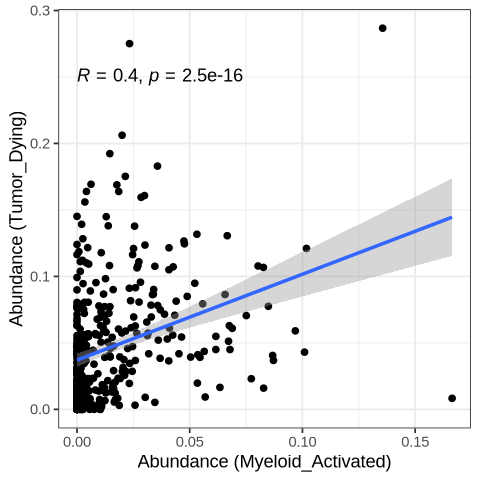

In [30]:
# t hub b hub
fig.size(4,4)
p1 <- tiles_wide_no_rt%>%
    ggplot(aes(x = B_Hub, y= T_Hub))+
        geom_point() + 
        theme_bw() + 
        geom_smooth(method = "lm")+
        stat_cor(label.y = 0.25,method = "spearman")+
        xlab("Abundance (B_Hub)") + 
        ylab("Abundance (T_Hub)") 

p2 <- tiles_wide_no_rt%>%
    ggplot(aes(x = Myeloid_Activated, y= Tumor_Dying))+
        geom_point() + 
        theme_bw() + 
        geom_smooth(method = "lm")+
        stat_cor(label.y = 0.25,method = "spearman")+
        xlab("Abundance (Myeloid_Activated)") + 
        ylab("Abundance (Tumor_Dying)") 
p1
p2

## Select samples for spatial niche plots

In [31]:
bad_samples <- c("D402", "D377", "D018", "D126", "D267")
top_sections <- survival_df %>% 
    filter(!(Section %in% c(bad_samples))) %>%
    mutate(margin_dist = sqrt((Lymphoid_Hub - 0.05)^2 + (Myeloid_Hub - 0.05)^2)) %>% # order samples by distance from cutoff boundaries
    group_by(group) %>%
    arrange(-margin_dist) %>% 
    slice(1:8) %>%
    select(group, Section, margin_dist) %>% 
    filter(!(group %in% c("Pauci-Immune")))


samples <- top_sections$Section

samples
top_sections

[1] "D409" "D177" "D414" "D271" "D316" "D307" "D194" "D186" "D329" "D038"
[11] "D360" "D143" "D221" "D241" "D283" "D053" "D161" "D182" "D292" "D257"
[21] "D285" "D102" "D078" "D284"

group,Section,margin_dist
<fct>,<chr>,<dbl>
Double-Positive,D409,0.2771592
Double-Positive,D177,0.1973555
Double-Positive,D414,0.1673959
Double-Positive,D271,0.1535891
Double-Positive,D316,0.1487984
Double-Positive,D307,0.1348886
Double-Positive,D194,0.1313481
Double-Positive,D186,0.1305107
Lymphoid Hub Only,D329,0.1993613


## Supp 10G. Spatial niche plots of representative Lymphoid Hub Only samples.

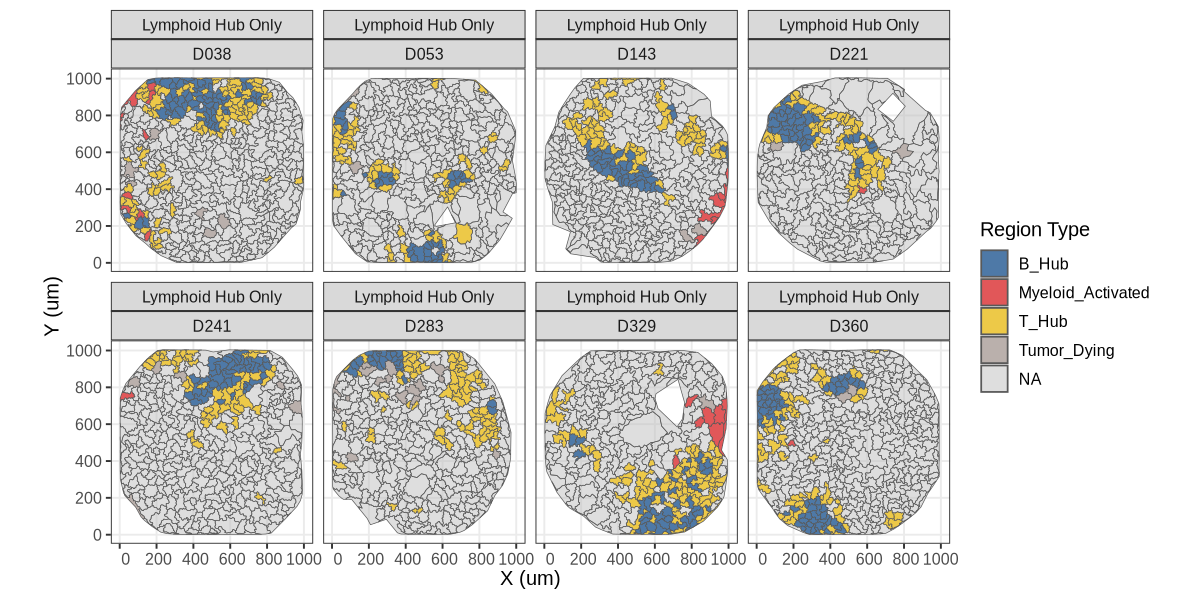

In [32]:
fig.size(5,10)
sig_clusters <- c("B_Hub", "Myeloid_Activated", "T_Hub", "Tumor_Dying")
obj_agg_shapes@meta.data %>% 
    left_join(cluster_map, by = c("seurat_clusters" = "tile_clus")) %>%
    filter(Section %in% samples) %>% 
    st_as_sf(sf_column_name = "shape") %>% 
    left_join(top_sections, by = c("Section")) %>% 
    filter(group == "Lymphoid Hub Only") %>%
    #left_join(select(survival_df, SampleID, group),  by = c("Section" = "SampleID")) #%>%
    # filter(Section %in% samples) #%>%
    mutate(tile_cluster = if_else(mid_tile_id %in% sig_clusters, mid_tile_id, NA)) %>% 
    # # # #filter(Section %in% unique(obj_agg@meta.data$Section)[1:100]) %>% 
    ggplot() + 
        #geom_point(size = 0.1) + 
        geom_sf(aes(geometry = shape, fill = tile_cluster))+
        scale_fill_manual(values= fig_cols, na.value = scales::alpha("grey", .5), name = "Region Type") +
        #scale_color_tableau(palette= "Tableau 20") +
        theme_bw(base_size = 12) +
        facet_wrap(~group + Section, nrow= 2) + 
        coord_sf()+
        theme(legend.position = "right") +
        xlab("X (um)") +
        ylab("Y (um)")

## Supp 10H. Spatial niche plots of representative Myeloid Hub Only samples.

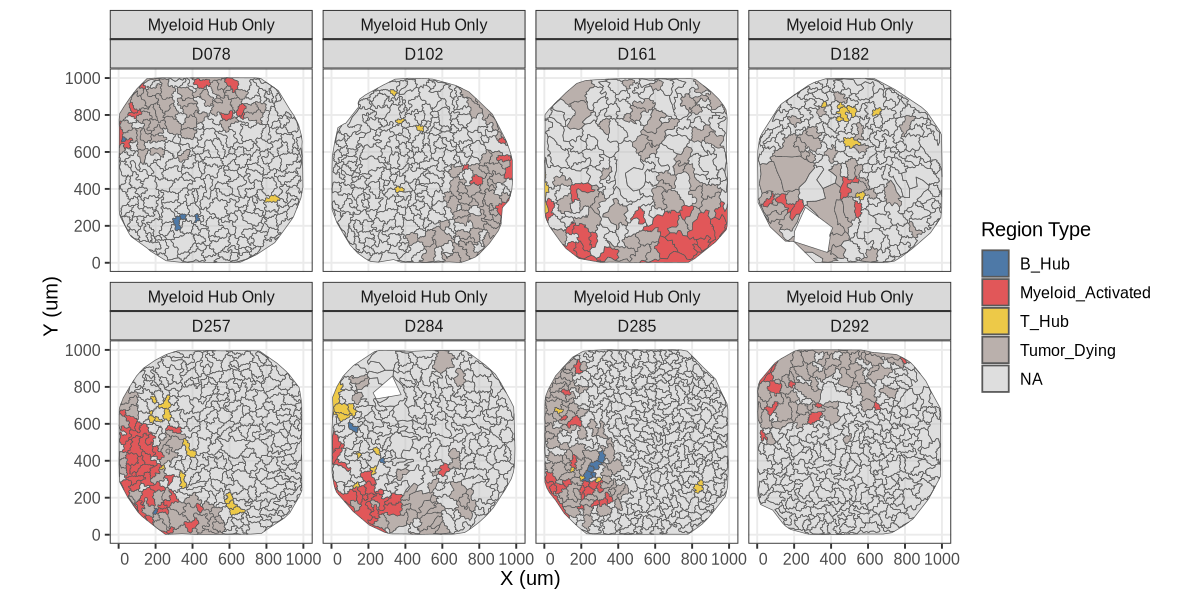

In [33]:
fig.size(5,10)
sig_clusters <- c("B_Hub", "Myeloid_Activated", "T_Hub", "Tumor_Dying")
obj_agg_shapes@meta.data %>% 
    left_join(cluster_map, by = c("seurat_clusters" = "tile_clus")) %>%
    filter(Section %in% samples) %>% 
    st_as_sf(sf_column_name = "shape") %>% 
    left_join(top_sections, by = c("Section")) %>% 
    filter(group == "Myeloid Hub Only") %>%
    #left_join(select(survival_df, SampleID, group),  by = c("Section" = "SampleID")) #%>%
    # filter(Section %in% samples) #%>%
    mutate(tile_cluster = if_else(mid_tile_id %in% sig_clusters, mid_tile_id, NA)) %>% 
    # # # #filter(Section %in% unique(obj_agg@meta.data$Section)[1:100]) %>% 
    ggplot() + 
        #geom_point(size = 0.1) + 
        geom_sf(aes(geometry = shape, fill = tile_cluster))+
        scale_fill_manual(values= fig_cols, na.value = scales::alpha("grey", .5), name = "Region Type") +
        #scale_color_tableau(palette= "Tableau 20") +
        theme_bw(base_size = 12) +
        facet_wrap(~group + Section, nrow= 2) + 
        coord_sf()+
        theme(legend.position = "right") +
        xlab("X (um)") +
        ylab("Y (um)")

## Supp. 10I KM analysis of One AT Hub vs no AT Hubs

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + group3 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df3 %>% filter(!is.na(group3)))

                    coef exp(coef) se(coef)      z        p
group31_AT_hub   -0.3256    0.7221   0.1458 -2.233   0.0256
age_bin           0.5284    1.6962   0.2287  2.310   0.0209
smoking_stat_bin -0.5100    0.6005   0.2913 -1.751   0.0800
bmi_bin          -0.1520    0.8590   0.2053 -0.740   0.4590
sex_bin          -0.1125    0.8936   0.1446 -0.778   0.4367
stage_bin         1.1725    3.2300   0.1882  6.230 4.68e-10

Likelihood ratio test=48.06  on 6 df, p=1.152e-08
n= 352, number of events= 198 
   (3 observations deleted due to missingness)

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df3 %>% filter(!is.na(group3)))

                     coef exp(coef) se(coef)      z        p
age_bin           0.59940   1.82102  0.22658  2.645  0.00816
smoking_stat_bin -0.47118   0.62427  0.29053 -1.622  0.10485
bmi_bin          -0.15802   0.85383  0.20512 -0.770  0.44107
sex_bin          -0.08581   0.91777  0.14421 -0.595  0.55182
stage_bin         1.23606   3.44204  0.18607  6.643 3.07e-11

Likelihood ratio test=43.08  on 5 df, p=3.559e-08
n= 352, number of events= 198 
   (3 observations deleted due to missingness)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-1018.112,NA,NA,NA
2,-1015.624,4.974799,1,0.02571919


[1] 0.02571919

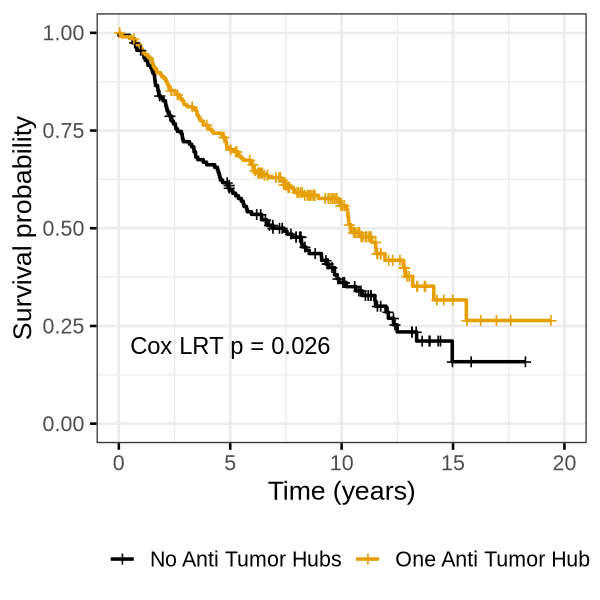

In [34]:
# KM fit for 1 group vs none
survival_df3 <- survival_df %>%
    mutate(group3 = case_when(group %in% c("Lymphoid Hub Only", "Myeloid Hub Only") ~ "1_AT_hub",
                              group == "Pauci-Immune" ~ "0_AT_hubs"
                             ))

fit3 <- survfit(Surv(survival, death_bin) ~ 1 + group3, data = survival_df3, type = "kaplan-meier")
#explicit lrt
full_fit_at_1v0 <- coxph(as.formula("Surv(survival, death_bin) ~  1 + group3 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df3%>% filter(!is.na(group3)))
null_fit_at_1v0 <- coxph(as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df3%>% filter(!is.na(group3)))

full_fit_at_1v0
null_fit_at_1v0

lrt_res <- anova(null_fit_at_1v0, full_fit_at_1v0)

full_fit_pval <- lrt_res[2,"Pr(>|Chi|)"]

lrt_res

full_fit_pval

fig.size(5,5)
p3f <- ggsurvplot(fit3, data = survival_df3, pval = FALSE, ggtheme = theme_bw(base_size= 16), legend = "bottom", legend.title= "")
p3f$plot + 
    annotate("text", x = 5, y = 0.2, label = paste("Cox LRT p =", format(full_fit_pval, digits = 2)), size = 5) + 
    scale_color_colorblind(labels = c("No Anti Tumor Hubs", "One Anti Tumor Hub")) +
    xlab("Time (years)")

## Supp 10J. KM analysis of Lymphoid Hub only vs. Myeloid Hub only.

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + group4 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df4 %>% filter(!is.na(group4)))

                           coef exp(coef) se(coef)      z        p
group4Lymphoid Hub Only  0.2163    1.2415   0.2405  0.899    0.368
group4Myeloid Hub Only       NA        NA   0.0000     NA       NA
group4Pauci-Immune           NA        NA   0.0000     NA       NA
age_bin                  0.4824    1.6200   0.4000  1.206    0.228
smoking_stat_bin        -0.3181    0.7276   0.4671 -0.681    0.496
bmi_bin                 -0.3576    0.6993   0.3136 -1.140    0.254
sex_bin                 -0.1644    0.8484   0.2107 -0.780    0.435
stage_bin                1.6370    5.1398   0.2810  5.826 5.67e-09

Likelihood ratio test=29.53  on 6 df, p=4.836e-05
n= 196, number of events= 96 
   (2 observations deleted due to missingness)

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df4 %>% filter(!is.na(group4)))

                    coef exp(coef) se(coef)      z        p
age_bin           0.4781    1.6131   0.3997  1.196    0.232
smoking_stat_bin -0.3404    0.7115   0.4659 -0.731    0.465
bmi_bin          -0.3860    0.6798   0.3118 -1.238    0.216
sex_bin          -0.1472    0.8631   0.2094 -0.703    0.482
stage_bin         1.5939    4.9228   0.2762  5.771 7.88e-09

Likelihood ratio test=28.74  on 5 df, p=2.606e-05
n= 196, number of events= 96 
   (2 observations deleted due to missingness)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-436.1426,NA,NA,NA
2,-435.7501,0.7851053,1,0.3755843


[1] 0.3755843

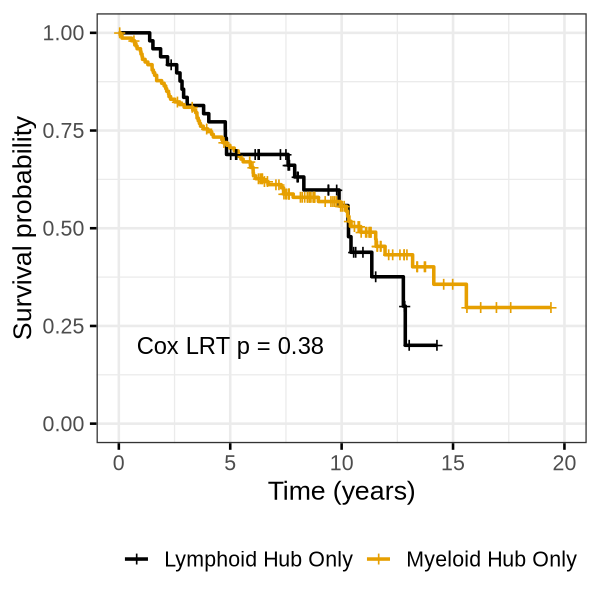

In [35]:
# lymph vs myl at niche
survival_df4 <- survival_df %>%
    mutate(group4 = if_else(group %in% c("Lymphoid Hub Only", "Myeloid Hub Only"), group, NA)
                             )

fit4 <- survfit(Surv(survival, death_bin) ~ group4, data = survival_df4, type = "kaplan-meier")

#explicit lrt
full_fit_at_mvl <- coxph(as.formula("Surv(survival, death_bin) ~  1 + group4 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df4%>% filter(!is.na(group4)))
null_fit_at_mvl <- coxph(as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df4%>% filter(!is.na(group4)))

full_fit_at_mvl
null_fit_at_mvl

lrt_res<- anova(null_fit_at_mvl, full_fit_at_mvl)

full_fit_pval <- lrt_res[2,"Pr(>|Chi|)"]

lrt_res

full_fit_pval

fig.size(5,5)
p4f <- ggsurvplot(fit4, data = survival_df4, pval = FALSE, ggtheme = theme_bw(base_size= 16), legend = "bottom", legend.title= "")
p4f$plot + 
    annotate("text", x = 5, y = 0.2, label = paste("Cox LRT p =", format(full_fit_pval, digits = 2)), size = 5) + 
    scale_color_colorblind(labels = c("Lymphoid Hub Only", "Myeloid Hub Only")) +
    xlab("Time (years)")

## Supp 10K. KM analysis of double postive vs lymphoid hub only.

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + group5 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df5 %>% filter(!is.na(group5)))

                           coef exp(coef) se(coef)      z       p
group5Lymphoid Hub Only  1.2910    3.6362   0.4700  2.747 0.00602
group5Myeloid Hub Only       NA        NA   0.0000     NA      NA
group5Pauci-Immune           NA        NA   0.0000     NA      NA
age_bin                  0.8548    2.3508   0.6009  1.423 0.15486
smoking_stat_bin        -0.1295    0.8785   0.7689 -0.168 0.86621
bmi_bin                  0.4791    1.6147   0.5571  0.860 0.38977
sex_bin                  0.2585    1.2950   0.4205  0.615 0.53877
stage_bin                1.6750    5.3390   0.5945  2.817 0.00484

Likelihood ratio test=13.27  on 6 df, p=0.03901
n= 79, number of events= 32 

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df5 %>% filter(!is.na(group5)))

                    coef exp(coef) se(coef)     z      p
age_bin          0.45773   1.58049  0.57882 0.791 0.4291
smoking_stat_bin 0.04589   1.04696  0.74120 0.062 0.9506
bmi_bin          0.23196   1.26107  0.55190 0.420 0.6743
sex_bin          0.06923   1.07168  0.41063 0.169 0.8661
stage_bin        1.15887   3.18634  0.56203 2.062 0.0392

Likelihood ratio test=4.27  on 5 df, p=0.5115
n= 79, number of events= 32 

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-116.8956,NA,NA,NA
2,-112.3970,8.997204,1,0.00270393


[1] 0.00270393

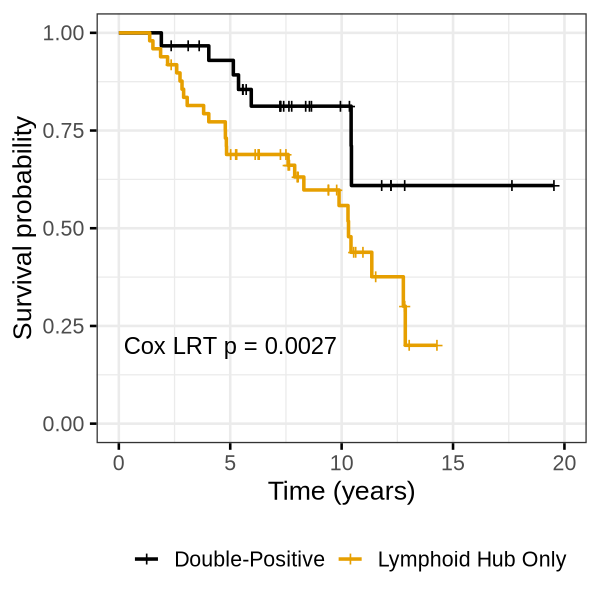

In [36]:
# douple pos vs lymph
survival_df5 <- survival_df %>%
    mutate(group5 = if_else(group %in% c("Lymphoid Hub Only", "Double-Positive"), group, NA)
                             )
fit5 <- survfit(Surv(survival, death_bin) ~ group5, data = survival_df5, type = "kaplan-meier")

# explicit lrt
full_fit_at_lvdp <- coxph(as.formula("Surv(survival, death_bin) ~  1 + group5 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df5%>% filter(!is.na(group5)))
null_fit_at_lvdp <- coxph(as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df5%>% filter(!is.na(group5)))

full_fit_at_lvdp
null_fit_at_lvdp

lrt_res <- anova(null_fit_at_lvdp, full_fit_at_lvdp)

full_fit_pval <- lrt_res[2,"Pr(>|Chi|)"]

lrt_res

full_fit_pval

fig.size(5,5)
p4f <- ggsurvplot(fit5, data = survival_df5, pval = FALSE, ggtheme = theme_bw(base_size= 16), legend = "bottom", legend.title= "")
p4f$plot + 
    annotate("text", x = 5, y = 0.2, label = paste("Cox LRT p =", format(full_fit_pval, digits = 2)), size = 5) + 
    scale_color_colorblind(labels = c("Double-Positive","Lymphoid Hub Only")) +
    xlab("Time (years)")

## Supp 10L. KM analyiss of double positive vs myeloid hub only.

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + group6 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df6 %>% filter(!is.na(group6)))

                           coef exp(coef) se(coef)      z       p
group6Lymphoid Hub Only      NA        NA   0.0000     NA      NA
group6Myeloid Hub Only   0.9642    2.6227   0.4101  2.351  0.0187
group6Pauci-Immune           NA        NA   0.0000     NA      NA
age_bin                  0.7009    2.0156   0.3711  1.889  0.0589
smoking_stat_bin        -0.7267    0.4835   0.5932 -1.225  0.2206
bmi_bin                 -0.7467    0.4739   0.3766 -1.982  0.0474
sex_bin                 -0.3477    0.7063   0.2366 -1.469  0.1418
stage_bin                1.5679    4.7967   0.2835  5.530 3.2e-08

Likelihood ratio test=41.85  on 6 df, p=1.971e-07
n= 177, number of events= 78 
   (2 observations deleted due to missingness)

Call:
coxph(formula = as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), 
    data = survival_df6 %>% filter(!is.na(group6)))

                    coef exp(coef) se(coef)      z        p
age_bin           0.4449    1.5603   0.3640  1.222   0.2216
smoking_stat_bin -0.6890    0.5021   0.5924 -1.163   0.2448
bmi_bin          -0.7114    0.4910   0.3763 -1.891   0.0587
sex_bin          -0.4639    0.6288   0.2353 -1.972   0.0486
stage_bin         1.4942    4.4555   0.2791  5.354 8.62e-08

Likelihood ratio test=34.93  on 5 df, p=1.554e-06
n= 177, number of events= 78 
   (2 observations deleted due to missingness)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-344.7675,NA,NA,NA
2,-341.3088,6.917281,1,0.008536666


[1] 0.008536666

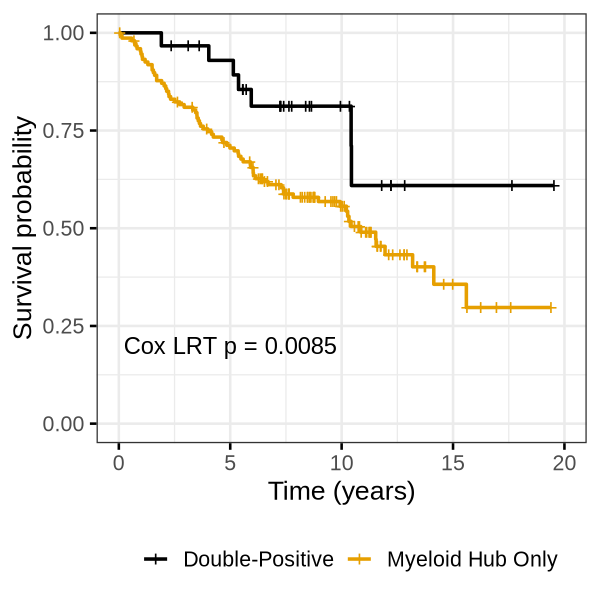

In [37]:
#km dp vs myl
survival_df6 <- survival_df %>%
    mutate(group6 = if_else(group %in% c("Double-Positive", "Myeloid Hub Only"), group, NA)
                             )
fit6 <- survfit(Surv(survival, death_bin) ~ group6, data = survival_df6, type = "kaplan-meier")

# explicit lrt
full_fit_at_mvdp <- coxph(as.formula("Surv(survival, death_bin) ~  1 + group6 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df6%>% filter(!is.na(group6)))
null_fit_at_mvdp <- coxph(as.formula("Surv(survival, death_bin) ~  1 + age_bin + smoking_stat_bin + bmi_bin + sex_bin + stage_bin"), data = survival_df6%>% filter(!is.na(group6)))

full_fit_at_mvdp
null_fit_at_mvdp

lrt_res<- anova(null_fit_at_mvdp, full_fit_at_mvdp)


full_fit_pval <- lrt_res[2,"Pr(>|Chi|)"]

lrt_res

full_fit_pval

fig.size(5,5)
p4f <- ggsurvplot(fit6, data = survival_df6, pval = FALSE, ggtheme = theme_bw(base_size= 16), legend = "bottom", legend.title= "")
p4f$plot + 
    annotate("text", x = 5, y = 0.2, label = paste("Cox LRT p =", format(full_fit_pval, digits = 2)), size = 5) + 
    scale_color_colorblind(labels = c("Double-Positive","Myeloid Hub Only")) +
    xlab("Time (years)")


## Supp 10M. Spatial niche plots of representative double positive samples.

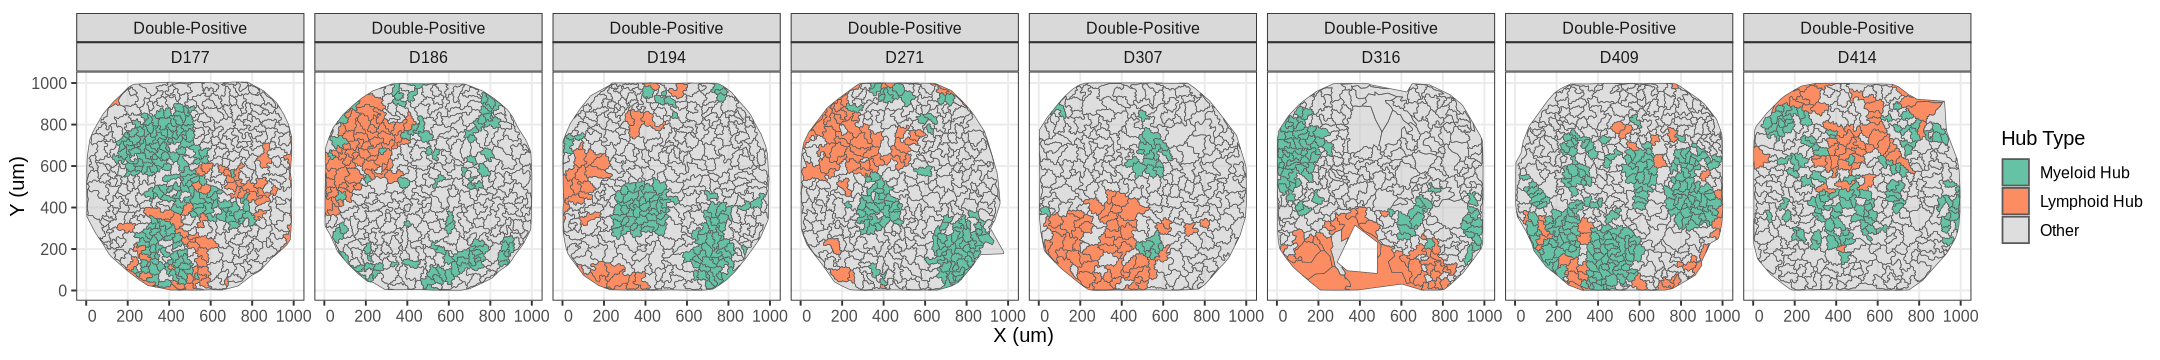

In [38]:
fig.size(3,18)
sig_clusters <- c("B_Hub", "Myeloid_Activated", "T_Hub", "Tumor_Dying")
obj_agg_shapes@meta.data %>% 
    left_join(cluster_map, by = c("seurat_clusters" = "tile_clus")) %>%
    filter(Section %in% samples) %>% 
    st_as_sf(sf_column_name = "shape") %>% 
    
    left_join(top_sections, by = c("Section")) %>% 
    filter(group == "Double-Positive") %>%

    mutate(meta_tile_id = case_when(
        mid_tile_id == "T_Hub" ~ "Lymphoid Hub", 
        mid_tile_id == "B_Hub" ~ "Lymphoid Hub", 
        mid_tile_id == "Myeloid_Activated" ~ "Myeloid Hub", 
        mid_tile_id == "Tumor_Dying" ~ "Myeloid Hub", 
        .default = NA
    )%>% as.factor) %>% 
    #left_join(select(survival_df, SampleID, group),  by = c("Section" = "SampleID")) #%>%
    # filter(Section %in% samples) #%>%
    mutate(tile_cluster = if_else(mid_tile_id %in% sig_clusters, mid_tile_id, NA)) %>% 
    # # # #filter(Section %in% unique(obj_agg@meta.data$Section)[1:100]) %>% 
    ggplot() + 
        #geom_point(size = 0.1) + 
        geom_sf(aes(geometry = shape, fill = meta_tile_id))+
        #scale_fill_manual(values= fig_cols, na.value = scales::alpha("grey", .5)) +
        scale_fill_brewer(palette= "Set2",name = "Hub Type", na.value = scales::alpha("grey", .5), labels = c("Myeloid Hub", "Lymphoid Hub", "Other"))+
        #scale_color_tableau(palette= "Tableau 20") +
        theme_bw(base_size = 12) +
        facet_wrap(~group + Section, nrow= 1) + 
        coord_sf()+
        theme(legend.position = "right") +
        xlab("X (um)") +
        ylab("Y (um)")